# --------------------------------Assigment 3 CNN- Human Protein------------------------------- 


![](https://www.researchgate.net/profile/Haleem_Farman/publication/321787151/figure/fig3/AS:673901872951307@1537682135746/CNN-general-architecture.jpg)

## Abstract
The Aim of this assignment is to study and predict the various protein structures in cellular images using Keras-CNN and having Tensorflow at backend for speedy prediction. I will be approaching to the prediction following the below mentioned sequaential process:
1. Encoding of binary target labels out of the given multilabel list per image,
2. Visual analysis of target protein distribution in the train set,
3. A simple image generator that yields images of a target-protein-wishlist. Each sample that has at least one match with this list is returned.
4. Some ideas on validation.
5. A baseline model build with keras that is supported by:
    * A modelparameter class that holds all parameters that are necessary to build the model, to load the data and to preprocess the images.
    * A data generator that can be used with CPU/GPU computing to perform training and validation.
    * An image preprocessor that rescales, reshapes and normalizes the images for feeding into the model.
6. Ideas on how to improve the baseline model by tracking loss with a keras callback, Tune hyperparameters 

## Our goal

* Predict various protein structures in cellular images
* there are 28 different target proteins
* multiple proteins can be present in one image (multilabel classification)
* 27 different cell types of highly different morphology

## Kernel settings

In [1]:
class KernelSettings:
    
    def __init__(self, fit_baseline=False,
                 fit_improved_baseline=True,
                 fit_improved_higher_batchsize=False,
                 fit_improved_without_dropout=False):
        self.fit_baseline = fit_baseline
        self.fit_improved_baseline = fit_improved_baseline
        self.fit_improved_higher_batchsize = fit_improved_higher_batchsize
        self.fit_improved_without_dropout = fit_improved_without_dropout

In [2]:
kernelsettings = KernelSettings(fit_baseline=False,
                                fit_improved_baseline=False,
                                fit_improved_higher_batchsize=False,
                                fit_improved_without_dropout=False)

In [3]:
use_dropout=True

## Importing the required Libraries

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from scipy.misc import imread

import tensorflow as tf
sns.set()

import os
print(os.listdir("../input"))

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Any results you write to the current directory are saved as output.

['protein-atlas-eab-predictions', 'human-protein-atlas-image-classification']


In [5]:
train_labels = pd.read_csv("../input/human-protein-atlas-image-classification/train.csv")
train_labels.head()

Id   Target
0  00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0
1  000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0
2  000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5
3  000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1
4  001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18

In [6]:
train_labels.shape[0]

31072

## Creating the Dictionary for the Target in the Train set

In [10]:
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

reverse_train_labels = dict((v,k) for k,v in label_names.items())

def fill_targets(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)
    for num in row.Target:
        name = label_names[int(num)]
        row.loc[name] = 1
    return row

## Extract train targets in the form of Binary Categorical Columns
* This way we can work on the 28 Protein Columns directly and ignore the Target Column

In [11]:
for key in label_names.keys():
    train_labels[label_names[key]] = 0

In [12]:
train_labels = train_labels.apply(fill_targets, axis=1)
train_labels.head()

Id     ...      Rods & rings
0  00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     ...                 0
1  000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0     ...                 0
2  000a9596-bbc4-11e8-b2bc-ac1f6b6435d0     ...                 0
3  000c99ba-bba4-11e8-b2b9-ac1f6b6435d0     ...                 0
4  001838f8-bbca-11e8-b2bc-ac1f6b6435d0     ...                 0

[5 rows x 30 columns]

# Exploratory data analysis <a class="anchor" id="explore"></a>

## Which proteins occur most often in train images?

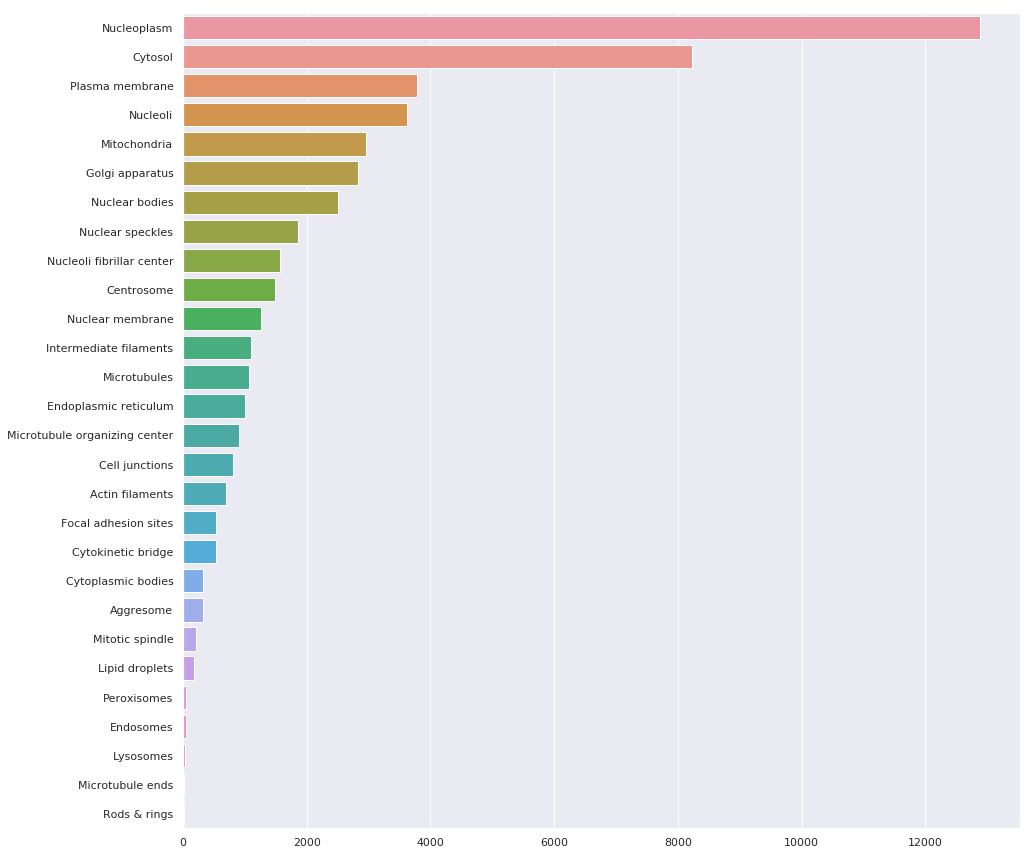

In [14]:
target_counts = train_labels.drop(["Id", "Target"],axis=1).sum(axis=0).sort_values(ascending=False)
plt.figure(figsize=(15,15))
sns.barplot(y=target_counts.index.values, x=target_counts.values, order=target_counts.index)

### Analysis

* We can see that most common protein structures belong to coarse grained cellular components like the plasma membrane, the cytosol and the nucleus. 
* In contrast small components like the lipid droplets, peroxisomes, endosomes, lysosomes, microtubule ends, rods and rings are very seldom in our train data. For these classes the prediction will be very difficult as we have only a few examples that may not cover all variabilities and as our model probably will be confused during ins learning process by the major classes. Due to this confusion we will make less accurate predictions on the minor classes.
* Consequently accuracy is not the right score here to measure your performance and validation strategy should be very fine. 

## How many targets are most common?

Text(0, 0.5, '% of train data')

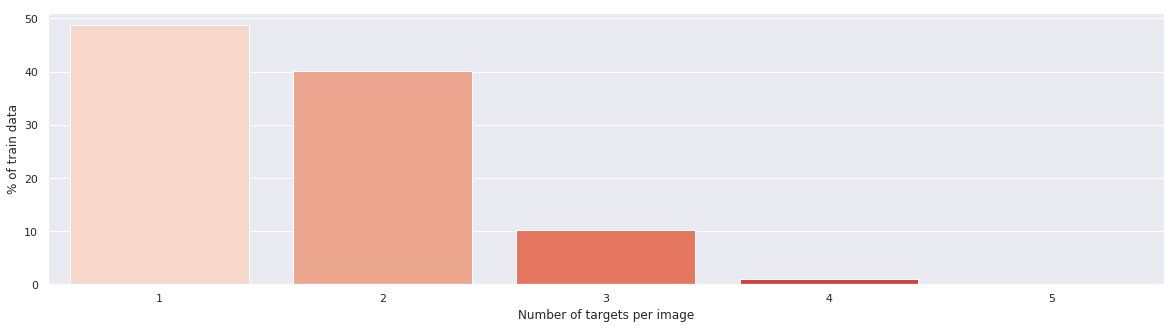

In [15]:
train_labels["number_of_targets"] = train_labels.drop(["Id", "Target"],axis=1).sum(axis=1)
count_perc = np.round(100 * train_labels["number_of_targets"].value_counts() / train_labels.shape[0], 2)
plt.figure(figsize=(20,5))
sns.barplot(x=count_perc.index.values, y=count_perc.values, palette="Reds")
plt.xlabel("Number of targets per image")
plt.ylabel("% of train data")

### Analysis

* Most train images only have 1 or two target labels.
* More than 3 targets are very seldom!

## Which protein targets/features are correlated?

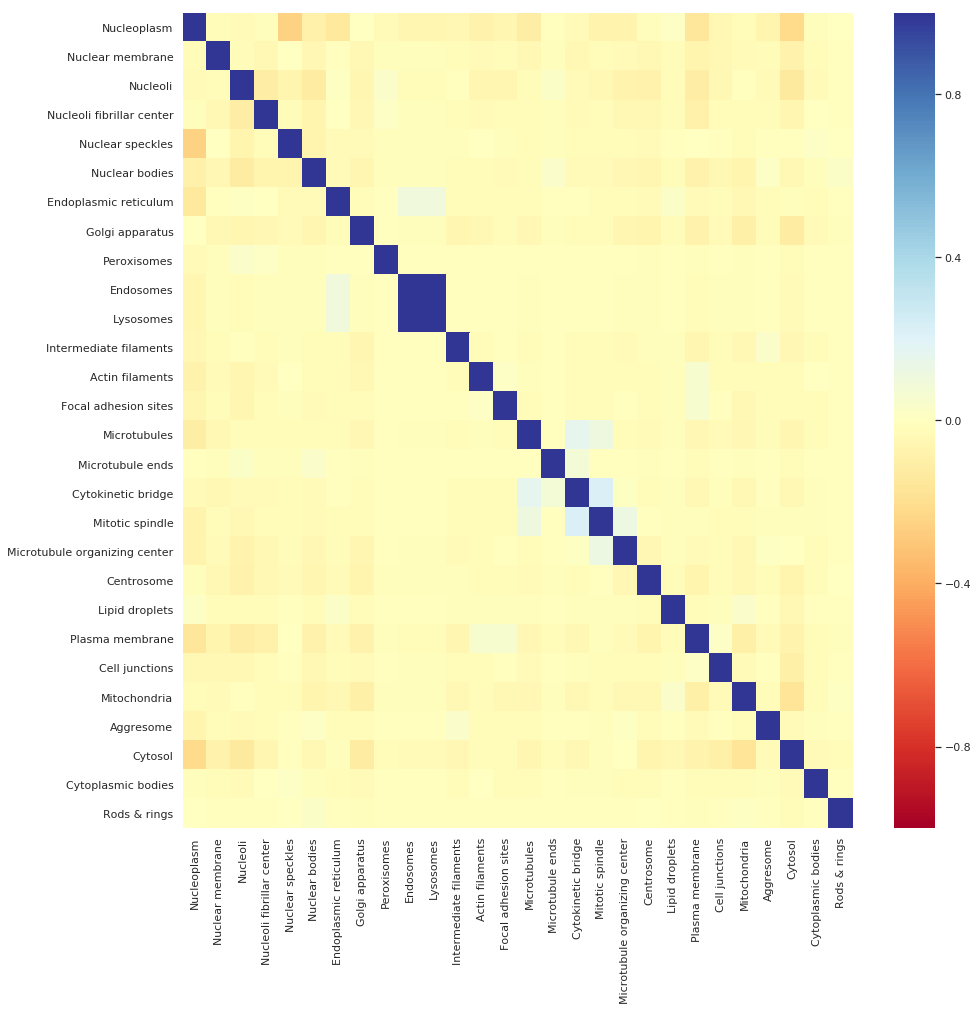

In [16]:
plt.figure(figsize=(15,15))
sns.heatmap(train_labels[train_labels.number_of_targets>1].drop(
    ["Id", "Target", "number_of_targets"],axis=1
).corr(), cmap="RdYlBu", vmin=-1, vmax=1)

## How are special and seldom targets grouped?

### Lysosomes and endosomes

In [17]:
def find_counts(special_target, labels):
    counts = labels[labels[special_target] == 1].drop(
        ["Id", "Target", "number_of_targets"],axis=1
    ).sum(axis=0)
    counts = counts[counts > 0]
    counts = counts.sort_values()
    return counts

Text(0, 0.5, 'Counts in train data')

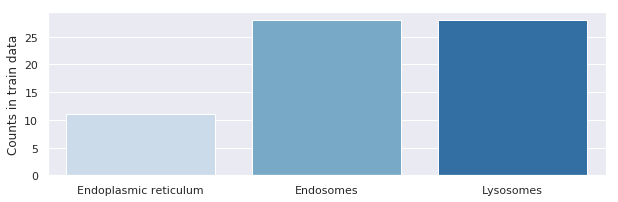

In [18]:
lyso_endo_counts = find_counts("Lysosomes", train_labels)

plt.figure(figsize=(10,3))
sns.barplot(x=lyso_endo_counts.index.values, y=lyso_endo_counts.values, palette="Blues")
plt.ylabel("Counts in train data")

### Rods and rings

Text(0, 0.5, 'Counts in train data')

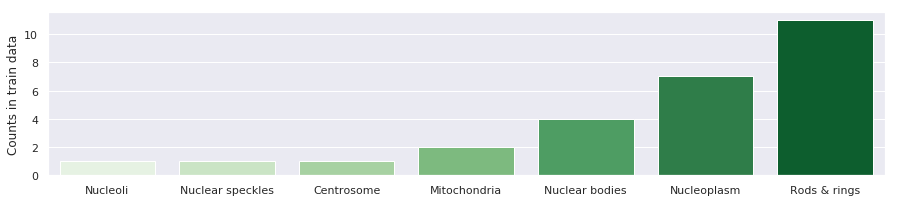

In [19]:
rod_rings_counts = find_counts("Rods & rings", train_labels)
plt.figure(figsize=(15,3))
sns.barplot(x=rod_rings_counts.index.values, y=rod_rings_counts.values, palette="Greens")
plt.ylabel("Counts in train data")

### Peroxisomes

Text(0, 0.5, 'Counts in train data')

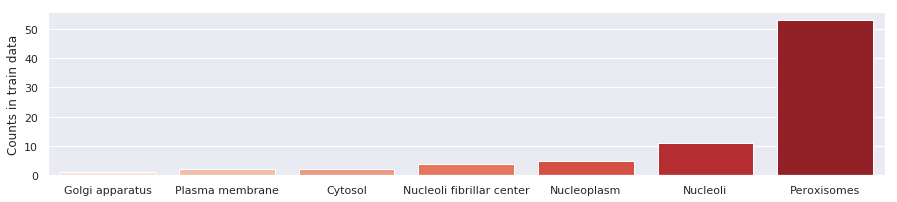

In [20]:
peroxi_counts = find_counts("Peroxisomes", train_labels)

plt.figure(figsize=(15,3))
sns.barplot(x=peroxi_counts.index.values, y=peroxi_counts.values, palette="Reds")
plt.ylabel("Counts in train data")

### Microtubule ends

Text(0, 0.5, 'Counts in train data')

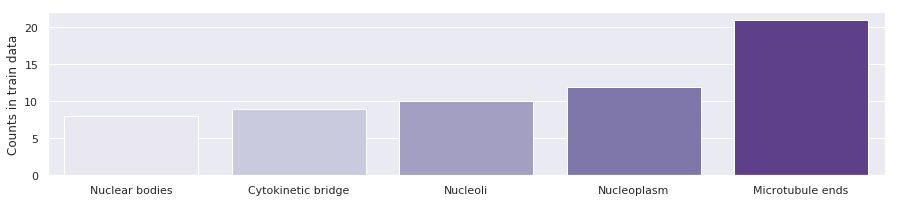

In [21]:
tubeends_counts = find_counts("Microtubule ends", train_labels)

plt.figure(figsize=(15,3))
sns.barplot(x=tubeends_counts.index.values, y=tubeends_counts.values, palette="Purples")
plt.ylabel("Counts in train data")

### Nuclear speckles

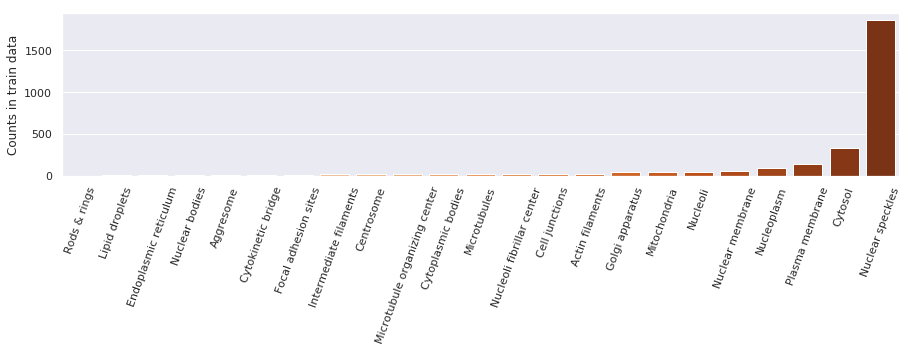

In [22]:
nuclear_speckles_counts = find_counts("Nuclear speckles", train_labels)

plt.figure(figsize=(15,3))
sns.barplot(x=nuclear_speckles_counts.index.values, y=nuclear_speckles_counts.values, palette="Oranges")
plt.xticks(rotation="70")
plt.ylabel("Counts in train data");

### Analysis

* We can see that even with very seldom targets we find some kind of grouping with other targets that reveal where the protein structure seems to be located. 
* For example, we can see that rods and rings have something to do with the nucleus whereas peroxisomes may be located in the nucleus as well as in the cytosol.  

## How do the images look like?



In [23]:
from os import listdir

files = listdir("../input/human-protein-atlas-image-classification/train")
for n in range(10):
    print(files[n])

ac39847a-bbb1-11e8-b2ba-ac1f6b6435d0_red.png
c0334bc0-bb9b-11e8-b2b9-ac1f6b6435d0_blue.png
731f0c26-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
615dde8a-bbbe-11e8-b2ba-ac1f6b6435d0_blue.png
d76d2d8c-bba6-11e8-b2ba-ac1f6b6435d0_blue.png
2e625b12-bbca-11e8-b2bc-ac1f6b6435d0_green.png
2ae23f8e-bbc5-11e8-b2bc-ac1f6b6435d0_green.png
783139e8-bbc0-11e8-b2bb-ac1f6b6435d0_blue.png
6cb84678-bba8-11e8-b2ba-ac1f6b6435d0_green.png
6ccb753c-bbc5-11e8-b2bc-ac1f6b6435d0_red.png


For one image id, there are different color channels present. Looking into the data description we can find that:

* Each image is actually splitted into 4 different image files. 
* These 4 files correspond to 4 different filter:
    * a **green** filter for the **target protein structure** of interest
    * **blue** landmark filter for the **nucleus**
    * **red** landmark filter for **microtubules**
    * **yellow** landmark filter for the **endoplasmatic reticulum**
* Each image is of size 512 x 512

Let's check if the number of files divided by 4 yields the number of target samples:

In [24]:
len(files) / 4 == train_labels.shape[0]

True

## How do images of specific targets look like?


In [25]:
train_path = "../input/human-protein-atlas-image-classification/train/"

In [26]:
def load_image(basepath, image_id):
    images = np.zeros(shape=(4,512,512))
    images[0,:,:] = imread(basepath + image_id + "_green" + ".png")
    images[1,:,:] = imread(basepath + image_id + "_red" + ".png")
    images[2,:,:] = imread(basepath + image_id + "_blue" + ".png")
    images[3,:,:] = imread(basepath + image_id + "_yellow" + ".png")
    return images

def make_image_row(image, subax, title):
    subax[0].imshow(image[0], cmap="Greens")
    subax[1].imshow(image[1], cmap="Reds")
    subax[1].set_title("stained microtubules")
    subax[2].imshow(image[2], cmap="Blues")
    subax[2].set_title("stained nucleus")
    subax[3].imshow(image[3], cmap="Oranges")
    subax[3].set_title("stained endoplasmatic reticulum")
    subax[0].set_title(title)
    return subax

def make_title(file_id):
    file_targets = train_labels.loc[train_labels.Id==file_id, "Target"].values[0]
    title = " - "
    for n in file_targets:
        title += label_names[n] + " - "
    return title

In [27]:
class TargetGroupIterator:
    
    def __init__(self, target_names, batch_size, basepath):
        self.target_names = target_names
        self.target_list = [reverse_train_labels[key] for key in target_names]
        self.batch_shape = (batch_size, 4, 512, 512)
        self.basepath = basepath
    
    def find_matching_data_entries(self):
        train_labels["check_col"] = train_labels.Target.apply(
            lambda l: self.check_subset(l)
        )
        self.images_identifier = train_labels[train_labels.check_col==1].Id.values
        train_labels.drop("check_col", axis=1, inplace=True)
    
    def check_subset(self, targets):
        return np.where(set(targets).issubset(set(self.target_list)), 1, 0)
    
    def get_loader(self):
        filenames = []
        idx = 0
        images = np.zeros(self.batch_shape)
        for image_id in self.images_identifier:
            images[idx,:,:,:] = load_image(self.basepath, image_id)
            filenames.append(image_id)
            idx += 1
            if idx == self.batch_shape[0]:
                yield filenames, images
                filenames = []
                images = np.zeros(self.batch_shape)
                idx = 0
        if idx > 0:
            yield filenames, images
            

In [28]:
your_choice = ["Lysosomes", "Endosomes"]
your_batch_size = 20

In [29]:
imageloader = TargetGroupIterator(your_choice, your_batch_size, train_path)
imageloader.find_matching_data_entries()
iterator = imageloader.get_loader()

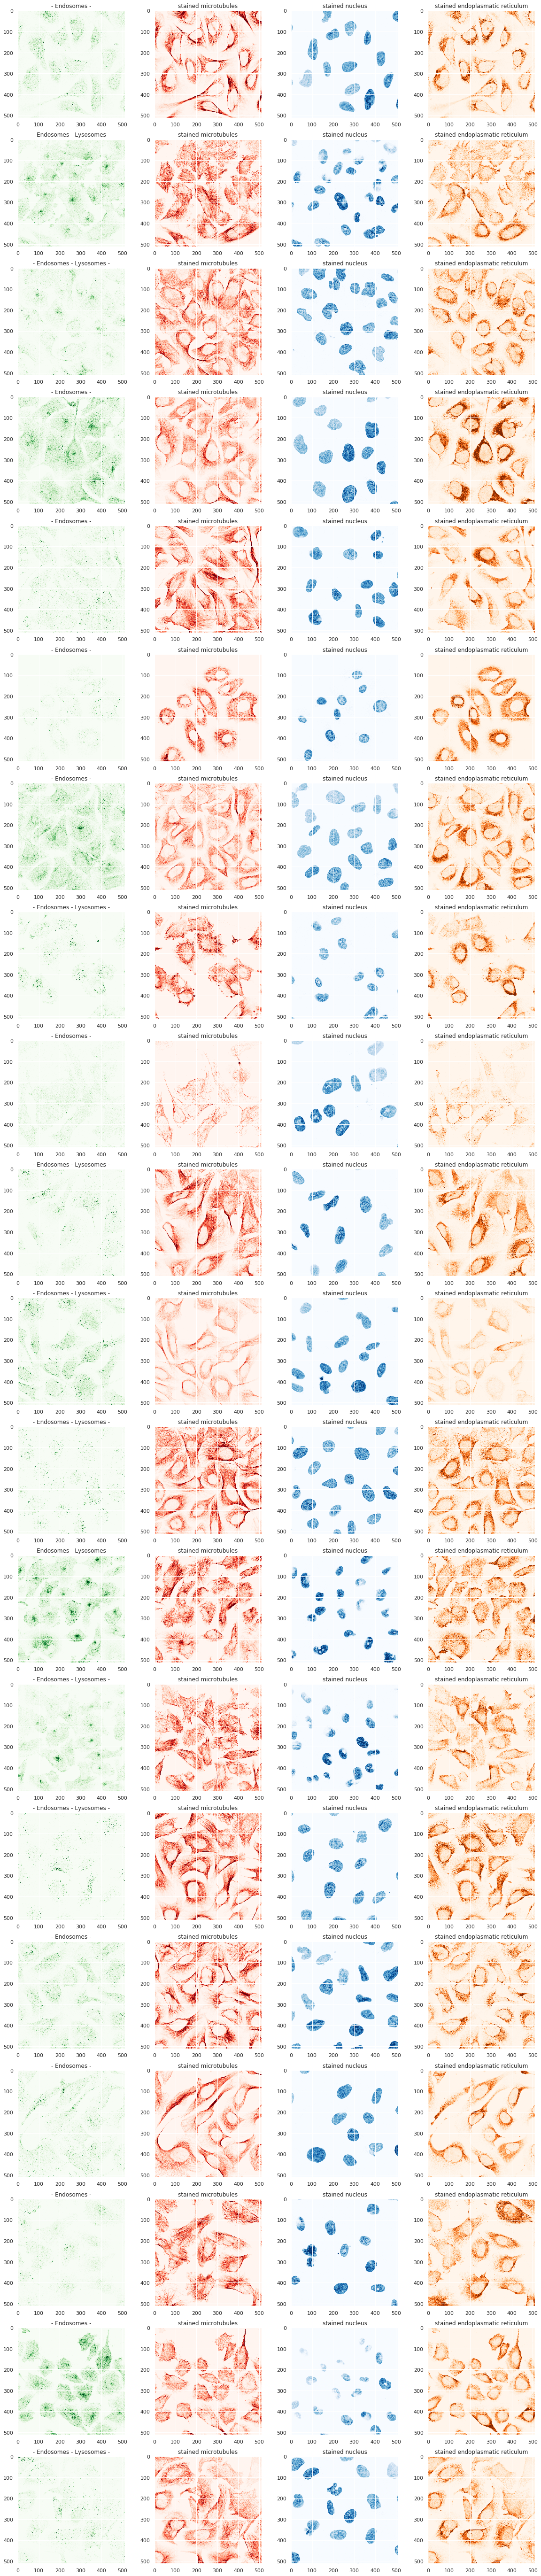

In [30]:
file_ids, images = next(iterator)

fig, ax = plt.subplots(len(file_ids),4,figsize=(20,5*len(file_ids)))
if ax.shape == (4,):
    ax = ax.reshape(1,-1)
for n in range(len(file_ids)):
    make_image_row(images[n], ax[n], make_title(file_ids[n]))

### Analysis

*  The **images differ in their intensities and the target proteins are not always located the same way**. The first image you can get by the loader shows endosomes that are spread all over the cells and in the second and third you can find endosomes and lysosomes more concetrated around the nucleus. 
    * Especially **in the red channel we can see morphological differences**.
* Sometimes the whole image is covered with cells and sometimes there are only a few**. In addition we can see that **some images have higher values whereas others are sallow with overall low values**. 

# Building a baseline model <a class="anchor" id="baseline"></a>

### K-Fold Cross-Validation

To understand the performance of our model we will use **k-fold cross validation**. The train data is splitted into k chunks and each chunk is used once for testing the prediction performance whereas the others are used for training. As our targets show relationships seemed to be grouped somehow the performance per test chunk probably highly depends on the target distribution per test chunk. For example there could be chunks with very seldom targets that may obtain a bad score and some chunks with very common targets and a very good score. To reduce this effect, we will **repeat the K-Fold several times** and look at scoing distributions in the end.

In [32]:
from sklearn.model_selection import RepeatedKFold

splitter = RepeatedKFold(n_splits=3, n_repeats=1, random_state=0)

In [33]:
partitions = []

for train_idx, test_idx in splitter.split(train_labels.index.values):
    partition = {}
    partition["train"] = train_labels.Id.values[train_idx]
    partition["validation"] = train_labels.Id.values[test_idx]
    partitions.append(partition)
    print("TRAIN:", train_idx, "TEST:", test_idx)
    print("TRAIN:", len(train_idx), "TEST:", len(test_idx))

TRAIN: [    1     2     3 ... 31063 31064 31065] TEST: [    0     4     6 ... 31069 31070 31071]
TRAIN: 20714 TEST: 10358
TRAIN: [    0     4     6 ... 31069 31070 31071] TEST: [    1     2     3 ... 31060 31061 31065]
TRAIN: 20715 TEST: 10357
TRAIN: [    0     1     2 ... 31069 31070 31071] TEST: [   10    11    13 ... 31062 31063 31064]
TRAIN: 20715 TEST: 10357


In [34]:
partitions[0]["train"][0:5]

array(['000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0',
       '000a9596-bbc4-11e8-b2bc-ac1f6b6435d0',
       '000c99ba-bba4-11e8-b2b9-ac1f6b6435d0',
       '001bcdd2-bbb2-11e8-b2ba-ac1f6b6435d0',
       '002daad6-bbc9-11e8-b2bc-ac1f6b6435d0'], dtype=object)

### Collecting ideas from the Competition Description for forming the Baseline Model

* To **stay simple let's use only the green channel image of our images per id**. The competition says that it shows the stained target proteins and consequently it's hopefully the most informative one. The other images are like references showing microtubules, nucleus and endoplasmatic reticulum. We don't acutally now how informative they are and in our current state they would blow up our neural network with a huge amount of network weigths that we might not need.

### Shared Parameter class

In [35]:
class ModelParameter:
    
    def __init__(self, basepath,
                 num_classes=28,
                 image_rows=512,
                 image_cols=512,
                 batch_size=200,
                 n_channels=1,
                 row_scale_factor=4,
                 col_scale_factor=4,
                 shuffle=False,
                 n_epochs=1):
        self.basepath = basepath
        self.num_classes = num_classes
        self.image_rows = image_rows
        self.image_cols = image_cols
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.row_scale_factor = row_scale_factor
        self.col_scale_factor = col_scale_factor
        self.scaled_row_dim = np.int(self.image_rows / self.row_scale_factor)
        self.scaled_col_dim = np.int(self.image_cols / self.col_scale_factor)
        self.n_epochs = n_epochs

In [36]:
parameter = ModelParameter(train_path)

### Image Preprocessor

In [37]:
from skimage.transform import resize

class ImagePreprocessor:
    
    def __init__(self, modelparameter):
        self.parameter = modelparameter
        self.basepath = self.parameter.basepath
        self.scaled_row_dim = self.parameter.scaled_row_dim
        self.scaled_col_dim = self.parameter.scaled_col_dim
        self.n_channels = self.parameter.n_channels
    
    def preprocess(self, image):
        image = self.resize(image)
        image = self.reshape(image)
        image = self.normalize(image)
        return image
    
    def resize(self, image):
        image = resize(image, (self.scaled_row_dim, self.scaled_col_dim))
        return image
    
    def reshape(self, image):
        image = np.reshape(image, (image.shape[0], image.shape[1], self.n_channels))
        return image
    
    def normalize(self, image):
        image /= 255 
        return image
    
    def load_image(self, image_id):
        image = np.zeros(shape=(512,512,4))
        image[:,:,0] = imread(self.basepath + image_id + "_green" + ".png")
        image[:,:,1] = imread(self.basepath + image_id + "_blue" + ".png")
        image[:,:,2] = imread(self.basepath + image_id + "_red" + ".png")
        image[:,:,3] = imread(self.basepath + image_id + "_yellow" + ".png")
        return image[:,:,0:self.parameter.n_channels]
        

In [38]:
preprocessor = ImagePreprocessor(parameter)

### Data Generator

In [40]:
import keras

class DataGenerator(keras.utils.Sequence):
    
    def __init__(self, list_IDs, labels, modelparameter, imagepreprocessor):
        self.current_epoch = 0
        self.params = modelparameter
        self.labels = labels
        self.list_IDs = list_IDs
        self.dim = (self.params.scaled_row_dim, self.params.scaled_col_dim)
        self.batch_size = self.params.batch_size
        self.n_channels = self.params.n_channels
        self.num_classes = self.params.num_classes
        self.shuffle = self.params.shuffle
        self.preprocessor = imagepreprocessor
        self.on_epoch_end()
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes, random_state=self.current_epoch)
            self.current_epoch += 1
    
    def get_targets_per_image(self, identifier):
        return self.labels.loc[self.labels.Id==identifier].drop(
                ["Id", "Target", "number_of_targets"], axis=1).values
            
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.num_classes), dtype=int)
        # Generate data
        for i, identifier in enumerate(list_IDs_temp):
            # Store sample
            image = self.preprocessor.load_image(identifier)
            image = self.preprocessor.preprocess(image)
            X[i] = image
            # Store class
            y[i] = self.get_targets_per_image(identifier)
        return X, y
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

Using TensorFlow backend.


In [41]:
class PredictGenerator:
    
    def __init__(self, predict_Ids, imagepreprocessor, predict_path):
        self.preprocessor = imagepreprocessor
        self.preprocessor.basepath = predict_path
        self.identifiers = predict_Ids
    
    def predict(self, model):
        y = np.empty(shape=(len(self.identifiers), self.preprocessor.parameter.num_classes))
        for n in range(len(self.identifiers)):
            image = self.preprocessor.load_image(self.identifiers[n])
            image = self.preprocessor.preprocess(image)
            image = image.reshape((1, *image.shape))
            y[n] = model.predict(image)
        return y

### CNN Baseline model using keras

##### Setting the required Leaderboard Arrays for performance evaluation:

In [17]:
MODEL_ID =[]
Act_Func=[]
Epochs=[]
Cost_Func=[]
Optimizer=[]
Dropout=[]
Accuracy=[]
Batch_Size=[]

In [42]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.losses import binary_crossentropy
from keras.optimizers import Adadelta
from keras.optimizers import Adam
from keras.initializers import VarianceScaling


class BaseLineModel:
    
    def __init__(self, modelparameter):
        self.params = modelparameter
        self.num_classes = self.params.num_classes
        self.img_rows = self.params.scaled_row_dim
        self.img_cols = self.params.scaled_col_dim
        self.n_channels = self.params.n_channels
        self.input_shape = (self.img_rows, self.img_cols, self.n_channels)
        self.my_metrics = ['accuracy']
    
    def build_model(self):
        self.model = Sequential()
        self.model.add(Conv2D(16, kernel_size=(3, 3), activation='tanh', input_shape=self.input_shape,
                             kernel_initializer=VarianceScaling(seed=0)))
        self.model.add(Conv2D(32, (3, 3), activation='tanh',
                             kernel_initializer=VarianceScaling(seed=0)))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Dropout(0.25))
        self.model.add(Flatten())
        self.model.add(Dense(64, activation='tanh',
                            kernel_initializer=VarianceScaling(seed=0),))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(self.num_classes, activation='sigmoid'))
    
    def compile_model(self):
        self.model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=self.my_metrics)
    
    def set_generators(self, train_generator, validation_generator):
        self.training_generator = train_generator
        self.validation_generator = validation_generator
    
    def learn(self):
        return self.model.fit_generator(generator=self.training_generator,
                    validation_data=self.validation_generator,
                    epochs=self.params.n_epochs, 
                    use_multiprocessing=True,
                    workers=8)
    
    def score(self):
        return self.model.evaluate_generator(generator=self.validation_generator,
                                      use_multiprocessing=True, 
                                      workers=8)
    
    def predict(self, predict_generator):
        y = predict_generator.predict(self.model)
        return y
    
    def save(self, modeloutputpath):
        self.model.save(modeloutputpath)
    
    def load(self, modelinputpath):
        self.model = load_model(modelinputpath)

### Training the baseline on the first cv-fold

First of all let's choose one partition of train and validation data:

In [43]:
# Datasets
partition = partitions[0]
labels = train_labels

print("Number of samples in train: {}".format(len(partition["train"])))
print("Number of samples in validation: {}".format(len(partition["validation"])))

Number of samples in train: 20714
Number of samples in validation: 10358


In [44]:
training_generator = DataGenerator(partition['train'], labels, parameter, preprocessor)
validation_generator = DataGenerator(partition['validation'], labels, parameter, preprocessor)

In [45]:
predict_generator = PredictGenerator(partition['validation'], preprocessor, train_path)

In [47]:
# Run computation and store results as csv
target_names = train_labels.drop(["Target", "number_of_targets", "Id"], axis=1).columns

if kernelsettings.fit_baseline == True:
    model = BaseLineModel(parameter)
    model.build_model()
    model.compile_model()
    model.set_generators(training_generator, validation_generator)
    history = model.learn()
    
    proba_predictions = model.predict(predict_generator)
    baseline_proba_predictions = pd.DataFrame(index = partition['validation'],
                                              data=proba_predictions,
                                              columns=target_names)
    baseline_proba_predictions.to_csv("baseline_predictions.csv")
    baseline_losses = pd.DataFrame(history.history["loss"], columns=["train_loss"])
    baseline_losses["val_loss"] = history.history["val_loss"]
    baseline_losses.to_csv("baseline_losses.csv")
    
# If you already have done a baseline fit once, 
# you can load predictions as csv and further fitting is not neccessary:
else:
    baseline_proba_predictions = pd.read_csv("../input/protein-atlas-eab-predictions/baseline_predictions.csv", index_col=0)
    baseline_losses = pd.read_csv("../input/protein-atlas-eab-predictions/baseline_losses.csv", index_col=0)

### What do the results tell us?

Let's have a look at predicted probabilites per target class:

In [48]:
validation_labels = train_labels.loc[train_labels.Id.isin(partition["validation"])].copy()
validation_labels.shape

(10358, 31)

In [49]:
baseline_proba_predictions.shape

(10358, 28)

In [2]:
from sklearn.metrics import accuracy_score as accuracy

y_true = validation_labels.drop(["Id", "Target", "number_of_targets"], axis=1).values
y_pred = np.where(baseline_proba_predictions.values > 0.5, 1, 0)

accuracy(y_true.flatten(), y_pred.flatten())

0.7973243593633631

In [15]:
Accuracy.append(y_true.flatten(), y_pred.flatten())
MODEL_ID.append('Baseline Model')
Act_Func.append('tanh')
Epochs.append(1)
Cost_Func.append('binary_crossentropy')
Dropout.append('25%')
Optimizer.append('Adadelta')
Batch_Size.append(200)

In [51]:
y_pred[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [52]:
y_true[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

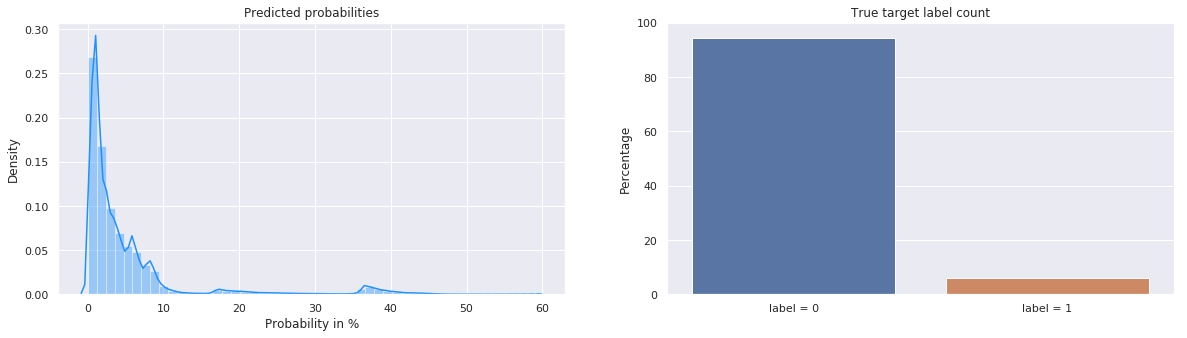

In [53]:
proba_predictions = baseline_proba_predictions.values
hot_values = validation_labels.drop(["Id", "Target", "number_of_targets"], axis=1).values.flatten()
one_hot = (hot_values.sum()) / hot_values.shape[0] * 100
zero_hot = (hot_values.shape[0] - hot_values.sum()) / hot_values.shape[0] * 100

fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.distplot(proba_predictions.flatten() * 100, color="DodgerBlue", ax=ax[0])
ax[0].set_xlabel("Probability in %")
ax[0].set_ylabel("Density")
ax[0].set_title("Predicted probabilities")
sns.barplot(x=["label = 0", "label = 1"], y=[zero_hot, one_hot], ax=ax[1])
ax[1].set_ylim([0,100])
ax[1].set_title("True target label count")
ax[1].set_ylabel("Percentage");

### Analysis

* We can see that our model was always very uncertain to predict the presence of a target protein. All probabilities are close to zero and there are only a few with targets where our model predicted a protein structure with higher than 10 %.
* If we take a look at the true target label count we can see that most of our targets are filled with zero. This corresponds to an absence of corresponding target proteins. This makes sense: For each image we have a high probability to contain either 1 or 2 target protein structures. Their label values are one whereas all others are zero. 

In [56]:
feature = "Cytosol"

(0, 1)

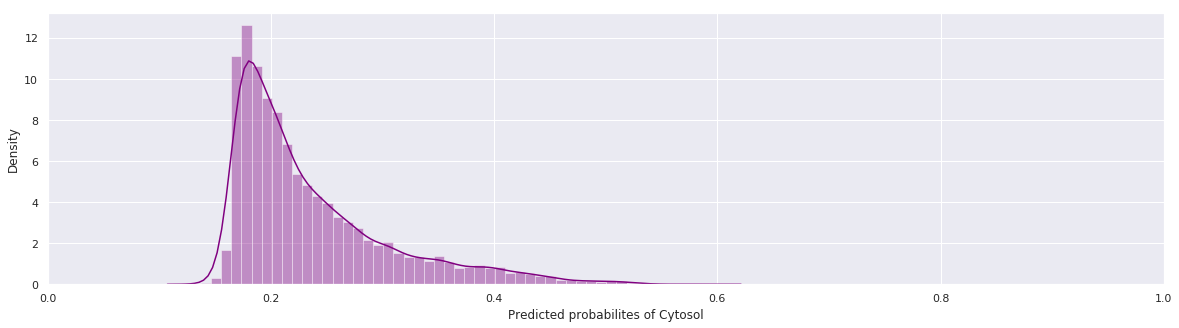

In [57]:
plt.figure(figsize=(20,5))
sns.distplot(baseline_proba_predictions[feature].values[0:-10], color="Purple")
plt.xlabel("Predicted probabilites of {}".format(feature))
plt.ylabel("Density")
plt.xlim([0,1])

No, it does not seem that our model starts to separate well. The mode is close to the fraction of one-hot-counts over all samples. At least the flat tail gives hope that learning could be in progress.  But even though our next goal should be to find out what to tune in such a way that our model really starts learning! 

# One-Step-Improvement Model <a class="anchor" id="onestep"></a>

In [58]:
wishlist = ["Nucleoplasm", "Cytosol", "Plasma membrane"]

In [59]:
class ImprovedDataGenerator(DataGenerator):
    
    # in contrast to the base DataGenerator we add a target wishlist to init
    def __init__(self, list_IDs, labels, modelparameter, imagepreprocessor, target_wishlist):
        super().__init__(list_IDs, labels, modelparameter, imagepreprocessor)
        self.target_wishlist = target_wishlist
    
    def get_targets_per_image(self, identifier):
        return self.labels.loc[self.labels.Id==identifier][self.target_wishlist].values

In [60]:
import keras.backend as K

def base_f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return f1

def f1_min(y_true, y_pred):
    f1 = base_f1(y_true, y_pred)
    return K.min(f1)

def f1_max(y_true, y_pred):
    f1 = base_f1(y_true, y_pred)
    return K.max(f1)

def f1_mean(y_true, y_pred):
    f1 = base_f1(y_true, y_pred)
    return K.mean(f1)

def f1_std(y_true, y_pred):
    f1 = base_f1(y_true, y_pred)
    return K.std(f1)

### Track losses and scores
 * Take a look at the loss values for train and validation data the notebook saved after learning after one epoch:

In [61]:
baseline_losses.head()

train_loss  val_loss
0    0.296079  0.176491

It does not contain losses that are obtained after computing each batch. But wait a minute... **How does our model update gradients? After each batch? After one epoch?** 

If we take a look at simple feedforward networks that are close related to **CNNs add gradient descent**, we can see that learning means to compute the derivatives of the loss with respect to the weights over all samples:

$$ w_{i,j}^{new} = w_{i,j}^{old} - \eta \cdot \partial_{w_{i,j}} E$$

With a set of independent observation samples, we can obtain the gradients this way:

$$ \partial_{w_{i,j}} E = \sum_{n=1}^{N} \partial_{w_{i,j}} E_{n}$$

We are computing the change of the loss with respect to a change in the weights for each sample one after another. Consequently in original gradient descent we need to pass the whole dataset once for just one single update step of gradient descent. As our initial weights are not sufficent to solve the classification task we need many such update steps. **But what if the dataset it too large to wait a long time just for one of these steps?**

Perhaps it would be sufficient and already good to use only some $M < N$ of the $N$ samples to compute the gradients $\partial_{w_{i,j}} E$:

$$ \partial_{w_{i,j}} E = \sum_{m=1}^{M} \partial_{w_{i,j}} E_{m} $$

This way **we could use only a batch of samples, compute the gradients and perform the update of weights**. After that we continue by computing the gradients with the next batch. This could be done in sequence of samples or random with replacement. This means that we already start learning without passing the whole dataset. In my case I chose a batch_size of 200. With a total number of samples of around 20000 in my training set this means that I have already done 200 weight updates. **After doing so I have used each sample once and this means the whole dataset was passed through gradient descent**. this means, **one epoch**. In addition we can now say that we want to shuffle the samples before doing weight updates after each batch again in the next epoch. This way our model sees a different set, computes some other gradients and hence the loss minimziation could be more robust.   

### Testing Increase in epochs!!! 

We can already see that we might need **more than 1 epoch to learn the pattern in the data**. Computing the gradient with batches is a stochastic process: Depending on the batch samples the gradients may sometimes lead to some good update directions in weight space that points to some minimum of loss.... and sometimes they could lead to the opposite. Well this really depends on the samples within one batch. This becomes more robust with **more samples per batch.** But then we will **need even more epochs** as we make less weight updata aka learning steps! But even if this stochastic gradient descent looks wiggly it has an advantage too: It can escape from local minima of the loss function.

Before we improve the model using more epochs and smaller batches, let's **implement a new feature: a loss callback**. This way we can see if the loss decreases during weight update steps! And we can see if we need more epochs or if the loss has already converged and settled down. 

In [62]:
class TrackHistory(keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [63]:
class ImprovedModel(BaseLineModel):
    
    def __init__(self, modelparameter,
                 use_dropout,
                 my_metrics=[f1_mean, f1_std, f1_min, f1_max]):
        
        super().__init__(modelparameter)
        self.my_metrics = my_metrics
        self.use_dropout = use_dropout
        
    def learn(self):
        self.history = TrackHistory()
        return self.model.fit_generator(generator=self.training_generator,
                    validation_data=self.validation_generator,
                    epochs=self.params.n_epochs, 
                    use_multiprocessing=True,
                    workers=8,
                    callbacks = [self.history])
    
    def build_model(self):
        self.model = Sequential()
        self.model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=self.input_shape,
                             kernel_initializer=VarianceScaling(seed=0),))
        self.model.add(Conv2D(32, (3, 3), activation='relu',
                             kernel_initializer=VarianceScaling(seed=0),))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        if self.use_dropout:
            self.model.add(Dropout(0.25))
        self.model.add(Flatten())
        self.model.add(Dense(64, activation='relu',
                            kernel_initializer=VarianceScaling(seed=0),))
        if self.use_dropout:
            self.model.add(Dropout(0.5))
        self.model.add(Dense(self.num_classes, activation='sigmoid'))
        
    def compile_model(self):
        self.model.compile(loss=keras.losses.binary_crossentropy,
              optimizer='adam',
              metrics=self.my_metrics)

### let's increase the number of epochs and decrease the batch_size.

In [64]:
parameter = ModelParameter(train_path, num_classes=len(wishlist), n_epochs=5, batch_size=64)
preprocessor = ImagePreprocessor(parameter)
labels = train_labels

In [65]:
training_generator = ImprovedDataGenerator(partition['train'], labels,
                                           parameter, preprocessor, wishlist)
validation_generator = ImprovedDataGenerator(partition['validation'], labels,
                                             parameter, preprocessor, wishlist)
predict_generator = PredictGenerator(partition['validation'], preprocessor, train_path)

In [67]:
# Run computation and store results as csv
if kernelsettings.fit_improved_baseline == True:
    model = ImprovedModel(parameter, use_dropout=use_dropout)
    model.build_model()
    model.compile_model()
    model.set_generators(training_generator, validation_generator)
    epoch_history = model.learn()
    proba_predictions = model.predict(predict_generator)
    #model.save("improved_model.h5")
    
    improved_proba_predictions = pd.DataFrame(proba_predictions, columns=wishlist)
    improved_proba_predictions.to_csv("improved_predictions.csv")
    improved_losses = pd.DataFrame(epoch_history.history["loss"], columns=["train_loss"])
    improved_losses["val_loss"] = epoch_history.history["val_loss"]
    improved_losses.to_csv("improved_losses.csv")
    improved_batch_losses = pd.DataFrame(model.history.losses, columns=["batch_losses"])
    improved_batch_losses.to_csv("improved_batch_losses.csv")
# If you already have done a baseline fit once, 
# you can load predictions as csv and further fitting is not neccessary:
else:
    improved_proba_predictions = pd.read_csv("../input/protein-atlas-eab-predictions/improved_predictions.csv", index_col=0)
    improved_losses= pd.read_csv("../input/protein-atlas-eab-predictions/improved_losses.csv", index_col=0)
    improved_batch_losses = pd.read_csv("../input/protein-atlas-eab-predictions/improved_batch_losses.csv", index_col=0)

In [3]:
y_true = validation_labels.drop(["Id", "Target", "number_of_targets"], axis=1).values
y_pred = np.where(improved_proba_predictions.values > 0.5, 1, 0)

accuracy(y_true.flatten(), y_pred.flatten())

0.9373243593633631

In [20]:
Accuracy.append(accuracy(y_true.flatten(), y_pred.flatten()))
MODEL_ID.append('Improved Model')
Act_Func.append('relu')
Epochs.append(5)
Cost_Func.append('binary_crossentropy')
Dropout.append('25%')
Optimizer.append('Adam')
Batch_Size.append(64)

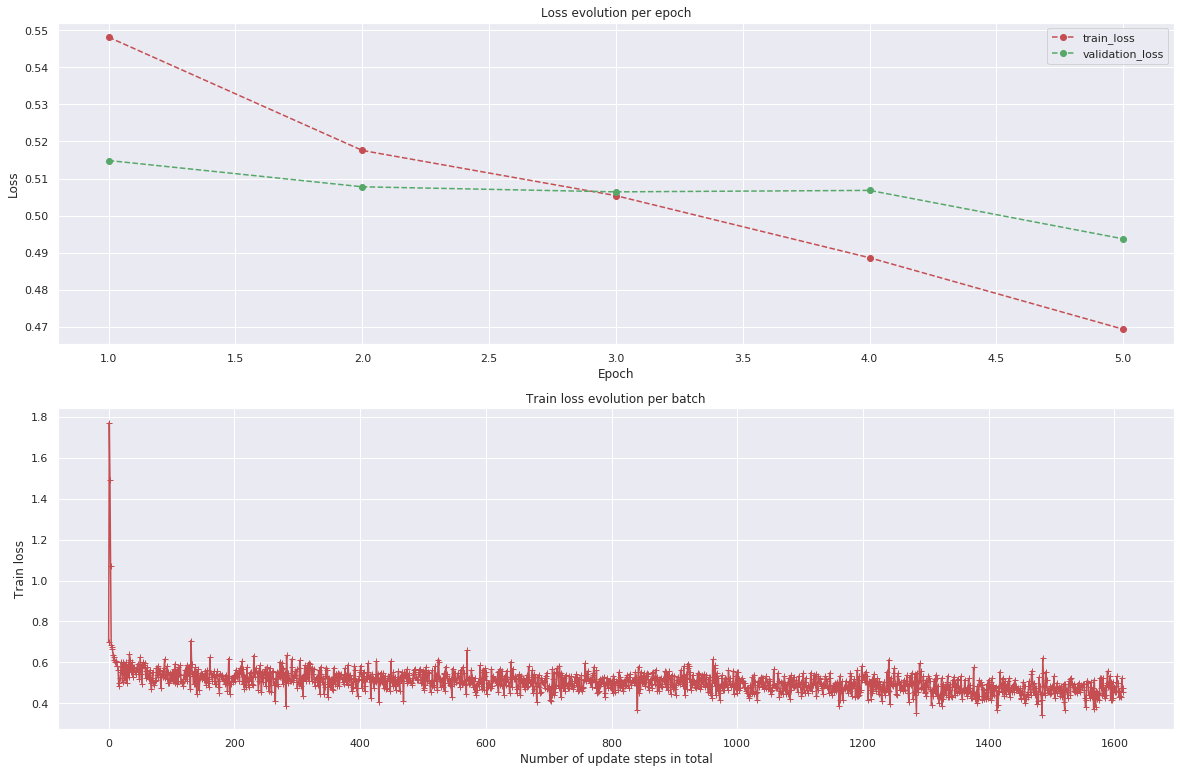

In [68]:
fig, ax = plt.subplots(2,1,figsize=(20,13))
ax[0].plot(np.arange(1,6), improved_losses["train_loss"].values, 'r--o', label="train_loss")
ax[0].plot(np.arange(1,6), improved_losses["val_loss"].values, 'g--o', label="validation_loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss evolution per epoch")
ax[0].legend()
ax[1].plot(improved_batch_losses.batch_losses.values, 'r-+', label="train_batch_losses")
ax[1].set_xlabel("Number of update steps in total")
ax[1].set_ylabel("Train loss")
ax[1].set_title("Train loss evolution per batch");

### What does the loss tell us?

The loss is very noisy! While decreasing the batch size we increased the number of learning steps. Hence our model learns faster. But... with smaller batch size there **are fewer samples to learn from, to compute gradients from**! The gradients we obtain may be very specific to the images and class labels that are covered by the batch of the current learning step. **There was a tradeoff we made**. We gained more learning speed but payed with a reduced gradient quality.

### Does our model try to classify?

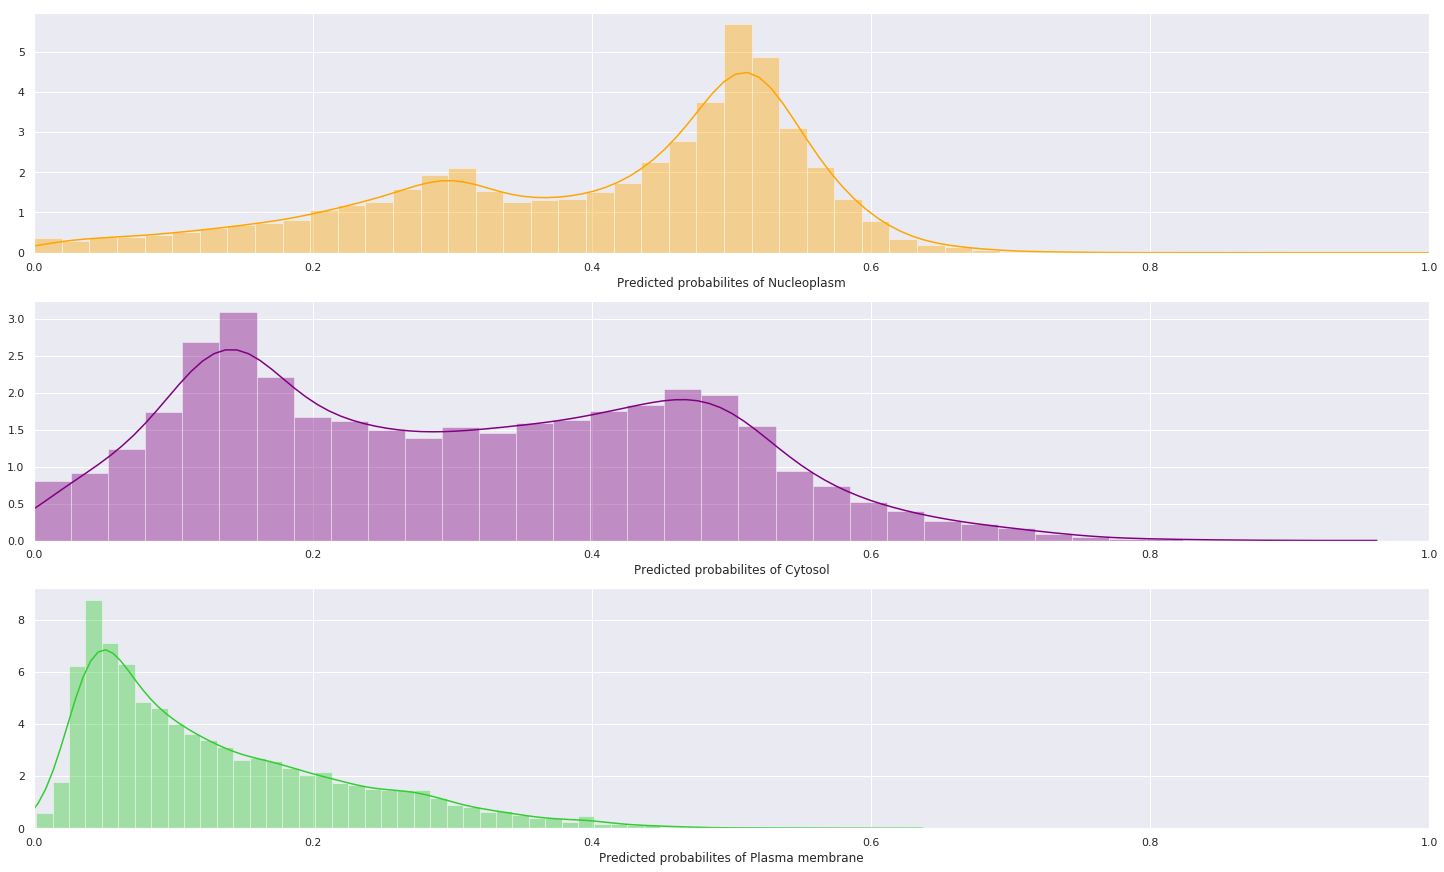

In [69]:
fig, ax = plt.subplots(3,1,figsize=(25,15))
sns.distplot(improved_proba_predictions.values[:,0], color="Orange", ax=ax[0])
ax[0].set_xlabel("Predicted probabilites of {}".format(improved_proba_predictions.columns.values[0]))
ax[0].set_xlim([0,1])
sns.distplot(improved_proba_predictions.values[:,1], color="Purple", ax=ax[1])
ax[1].set_xlabel("Predicted probabilites of {}".format(improved_proba_predictions.columns.values[1]))
ax[1].set_xlim([0,1])
sns.distplot(improved_proba_predictions.values[:,2], color="Limegreen", ax=ax[2])
ax[2].set_xlabel("Predicted probabilites of {}".format(improved_proba_predictions.columns.values[2]))
ax[2].set_xlim([0,1]);

Jeahy! This looks far better than the distributions we obtained with the baseline model! :-) **Thus increasing epochs while decreasing the batch size helped our model as we made more learning steps.** But... we can see a lot of noise after 100 batches during loss decrease. Consequently we make large jumps in weight space with each update step batch per batch. That's not nice! Sometimes these jumps could even lead to exploding losses as well. Then the jump was so big that we escaped from nice regions that lead to a local minimum of loss. 

## Analysis
This looks far better than the distributions we obtained with the baseline model!  **Thus increasing epochs while decreasing the batch size helped our model as we made more learning steps.** 

## How can we tackle gradient jiggles?

Let's try to dive deeper into the problem. We compute the gradients with respect to the weights after processing each batch this way:

$$ \partial_{w_{i,j}} E = \sum_{m=1}^{M} \partial_{w_{i,j}} E_{m} $$

Looking at the sum we can see one disadvantage... it's mainly driven by high contributions. **An image in the batch that causes very high positive or negative gradients for the weight $w_{i,j}$ have more impact on the overall gradient than images with low absolute values**. This can be bad especially in the case of outlier images that are not representative to explain the pattern in the data. Consequently our model may try to learn from exotics. In addition we have to be very **careful with small batches as its target distribution might not reflect the overall pattern**. 

Decreasing the batch size we made a tradeoff: We increased the learning speed but increased the risk of low quality gradients. Hence before playing with further strategies, we should make a step backwards again. With a batch_size of 128 and number of epochs 10, we obtain these losses:

In [81]:
parameter = ModelParameter(train_path, num_classes=len(wishlist), n_epochs=10, batch_size=128)
preprocessor = ImagePreprocessor(parameter)
labels = train_labels

training_generator = ImprovedDataGenerator(partition['train'], labels,
                                           parameter, preprocessor, wishlist)
validation_generator = ImprovedDataGenerator(partition['validation'], labels,
                                             parameter, preprocessor, wishlist)
predict_generator = PredictGenerator(partition['validation'], preprocessor, train_path)

In [82]:
# Run computation and store results as csv
if kernelsettings.fit_improved_higher_batchsize == True:
    model = ImprovedModel(parameter, use_dropout=True)
    model.build_model()
    model.compile_model()
    model.set_generators(training_generator, validation_generator)
    epoch_history = model.learn()
    proba_predictions = model.predict(predict_generator)
    #model.save("improved_model.h5")
    improved_proba_predictions = pd.DataFrame(proba_predictions, columns=wishlist)
    improved_proba_predictions.to_csv("improved_hbatch_predictions.csv")
    improved_losses = pd.DataFrame(epoch_history.history["loss"], columns=["train_loss"])
    improved_losses["val_loss"] = epoch_history.history["val_loss"]
    improved_losses.to_csv("improved_hbatch_losses.csv")
    improved_batch_losses = pd.DataFrame(model.history.losses, columns=["batch_losses"])
    improved_batch_losses.to_csv("improved_hbatch_batch_losses.csv")
# If you already have done a baseline fit once, 
# you can load predictions as csv and further fitting is not neccessary:
else:
    improved_proba_predictions = pd.read_csv(
        "../input/protein-atlas-eab-predictions/improved_hbatch_predictions.csv", index_col=0)
    improved_losses= pd.read_csv(
        "../input/protein-atlas-eab-predictions/improved_hbatch_losses.csv", index_col=0)
    improved_batch_losses = pd.read_csv("../input/protein-atlas-eab-predictions/improved_hbatch_batch_losses.csv", index_col=0)

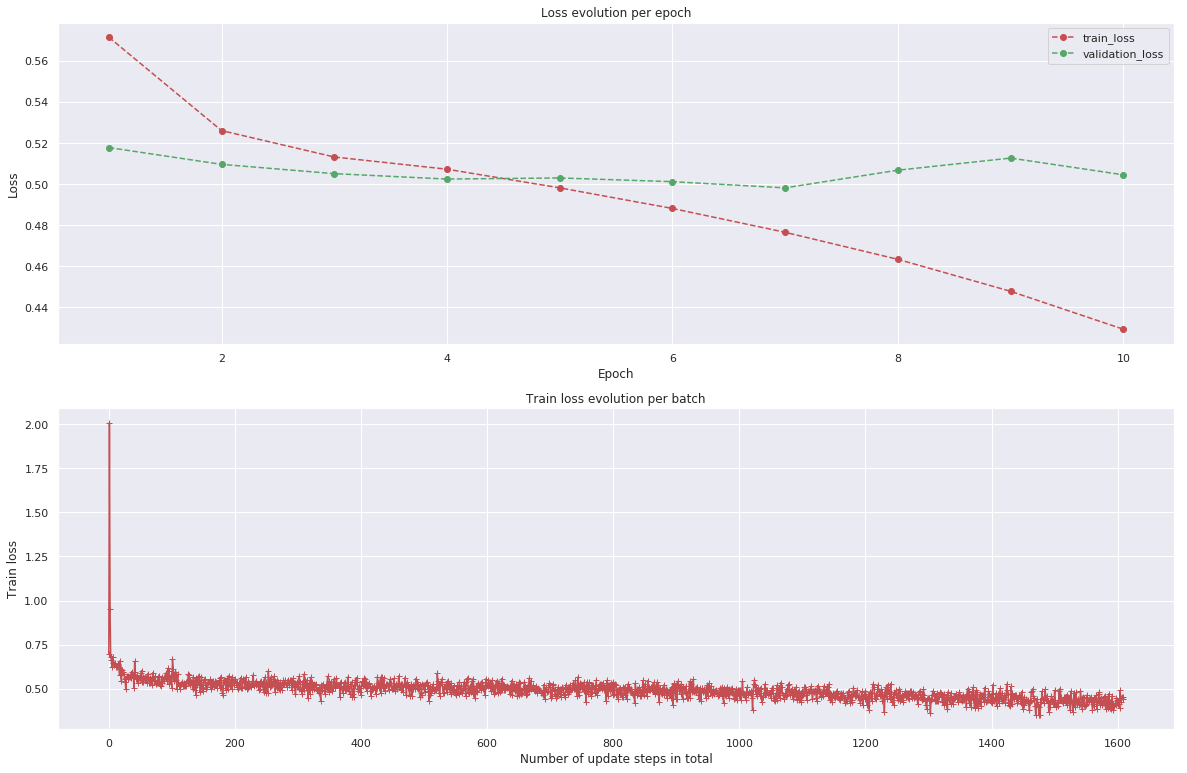

In [83]:
fig, ax = plt.subplots(2,1,figsize=(20,13))
ax[0].plot(np.arange(1,11), improved_losses["train_loss"].values, 'r--o', label="train_loss")
ax[0].plot(np.arange(1,11), improved_losses["val_loss"].values, 'g--o', label="validation_loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss evolution per epoch")
ax[0].legend()
ax[1].plot(improved_batch_losses.batch_losses.values, 'r-+', label="train_batch_losses")
ax[1].set_xlabel("Number of update steps in total")
ax[1].set_ylabel("Train loss")
ax[1].set_title("Train loss evolution per batch");

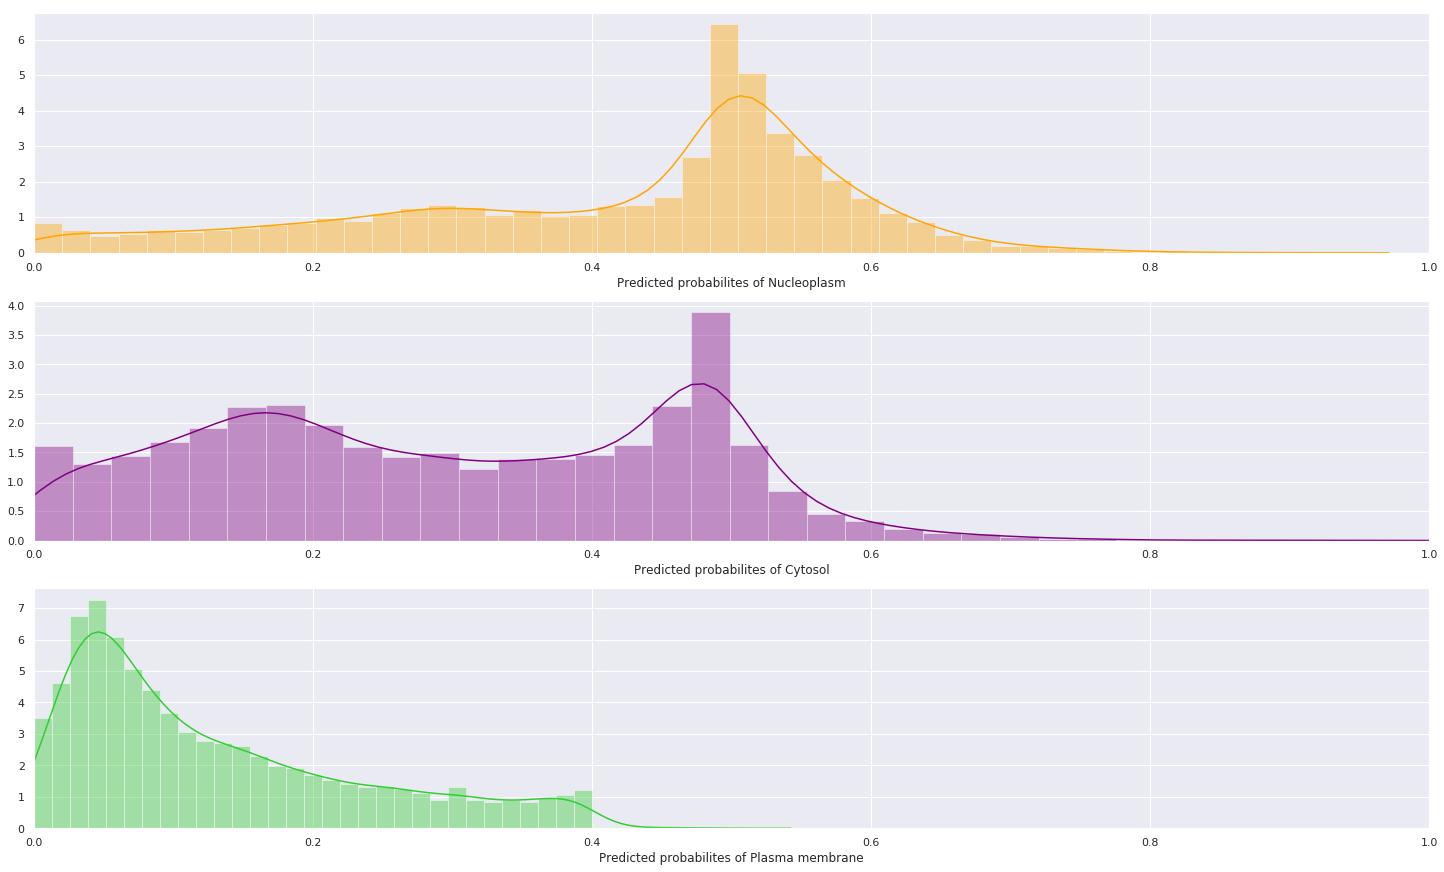

In [84]:
fig, ax = plt.subplots(3,1,figsize=(25,15))
sns.distplot(improved_proba_predictions.values[:,0], color="Orange", ax=ax[0])
ax[0].set_xlabel("Predicted probabilites of {}".format(improved_proba_predictions.columns.values[0]))
ax[0].set_xlim([0,1])
sns.distplot(improved_proba_predictions.values[:,1], color="Purple", ax=ax[1])
ax[1].set_xlabel("Predicted probabilites of {}".format(improved_proba_predictions.columns.values[1]))
ax[1].set_xlim([0,1])
sns.distplot(improved_proba_predictions.values[:,2], color="Limegreen", ax=ax[2])
ax[2].set_xlabel("Predicted probabilites of {}".format(improved_proba_predictions.columns.values[2]))
ax[2].set_xlim([0,1]);

### Dropout Layer

Consequently if you have a **problem with overfitting** (learning too much out of your training data and loosing generalization performance) **or you have very small, imbalanced batches you should consider dropout** as a strategy. 

Our last losses were obtained by using dropout with high percentage (25 % and 50 %) of dropped neurons. **What will happen if we do not use our dropout layers?**


In [85]:
# Run computation and store results as csv
if kernelsettings.fit_improved_without_dropout == True:
    model = ImprovedModel(parameter, use_dropout=False)
    model.build_model()
    model.compile_model()
    model.set_generators(training_generator, validation_generator)
    epoch_history = model.learn()
    proba_predictions = model.predict(predict_generator)
    #model.save("improved_model.h5")
    improved_proba_predictions = pd.DataFrame(proba_predictions, columns=wishlist)
    improved_proba_predictions.to_csv("improved_nodropout_predictions.csv")
    improved_losses = pd.DataFrame(epoch_history.history["loss"], columns=["train_loss"])
    improved_losses["val_loss"] = epoch_history.history["val_loss"]
    improved_losses.to_csv("improved_nodropout_losses.csv")
    improved_batch_losses = pd.DataFrame(model.history.losses, columns=["batch_losses"])
    improved_batch_losses.to_csv("improved_nodropout_batch_losses.csv")
# If you already have done a baseline fit once, 
# you can load predictions as csv and further fitting is not neccessary:
else:
    improved_proba_predictions_no_dropout = pd.read_csv(
        "../input/protein-atlas-eab-predictions/improved_nodropout_predictions.csv", index_col=0)
    improved_losses_no_dropout= pd.read_csv(
        "../input/protein-atlas-eab-predictions/improved_nodropout_losses.csv", index_col=0)
    improved_batch_losses_no_dropout = pd.read_csv(
        "../input/protein-atlas-eab-predictions/improved_nodropout_batch_losses.csv", index_col=0)

In [22]:
y_true = validation_labels.drop(["Id", "Target", "number_of_targets"], axis=1).values
y_pred = np.where(improved_proba_predictions.values > 0.5, 1, 0)

accuracy(y_true.flatten(), y_pred.flatten())

0.9174567856777675

In [23]:
Accuracy.append(accuracy(y_true.flatten(), y_pred.flatten()))
MODEL_ID.append('Model without Dropout')
Act_Func.append('relu')
Epochs.append(5)
Cost_Func.append('binary_crossentropy')
Dropout.append('-')
Optimizer.append('Adadelta')
Batch_Size.append(64)

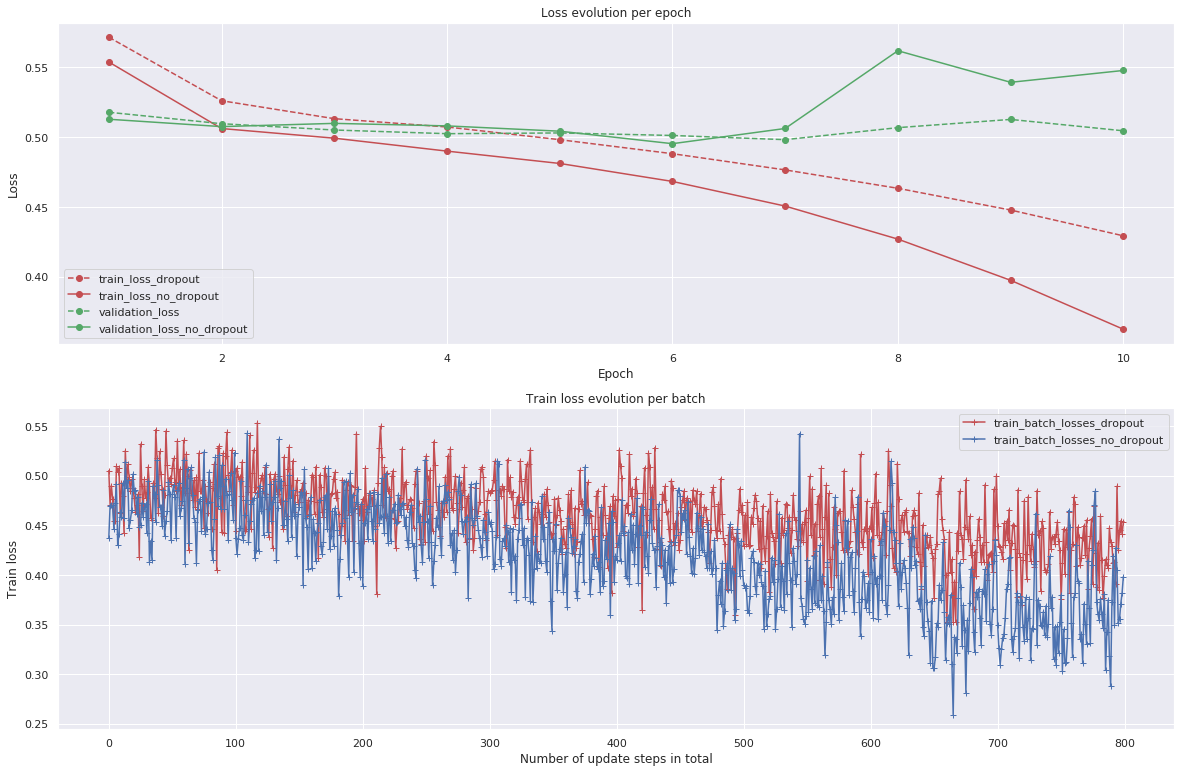

In [86]:
fig, ax = plt.subplots(2,1,figsize=(20,13))
ax[0].plot(np.arange(1,11), improved_losses["train_loss"].values, 'r--o', label="train_loss_dropout")
ax[0].plot(np.arange(1,11), improved_losses_no_dropout["train_loss"].values, 'r-o', label="train_loss_no_dropout")
ax[0].plot(np.arange(1,11), improved_losses["val_loss"].values, 'g--o', label="validation_loss")
ax[0].plot(np.arange(1,11), improved_losses_no_dropout["val_loss"].values, 'g-o', label="validation_loss_no_dropout")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss evolution per epoch")
ax[0].legend()
ax[1].plot(improved_batch_losses.batch_losses.values[-800::], 'r-+', label="train_batch_losses_dropout")
ax[1].plot(improved_batch_losses_no_dropout.batch_losses.values[-800::], 'b-+',
           label="train_batch_losses_no_dropout")
ax[1].set_xlabel("Number of update steps in total")
ax[1].set_ylabel("Train loss")
ax[1].set_title("Train loss evolution per batch");
ax[1].legend();

## Conclusion

In [41]:
leaderboard = pd.DataFrame({'Model_ID':MODEL_ID,'Activation Function':Act_Func,'Epochs':Epochs,'Batch_Size':Batch_Size,'Cost Function':Cost_Func,'Optimizer':Optimizer,'Dropout':Dropout,'Accuracy':Accuracy})
leaderboard

Model_ID Activation Function  Epochs  Batch_Size  \
0         Baseline Model                tanh       1         200   
1         Improved Model                relu       5          64   
2  Model without Dropout                relu       5          64   

         Cost Function Optimizer Dropout  Accuracy  
0  binary_crossentropy  Adadelta     25%  0.797324  
1  binary_crossentropy      Adam     25%  0.937324  
2  binary_crossentropy      Adam       -  0.917457

## Contributions
Code by self -- 30%

Code referred -- 70%

## Citations
https://www.kaggle.com/allunia/protein-atlas-exploration-and-baseline/

https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6

https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

# License
Copyright 2020 Anand Kumar

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.